<p style="color: darkred; font-size: 35px; text-align: center;"><b>Scraping Disease Outbreak News from WHO Website</b></p>
<p style="font-size: 20px; text-align: center;">Lei Hu</p>
<p style="font-size: 20px; text-align: center;">Spring 2025</p>

In today's fast-moving world, staying on top of disease outbreaks is more important than ever. The World Health Organization (WHO) regularly updates its Disease Outbreak News (DONs) portal with reports on global health threats. However, this information is only available on their website, making it hard to track trends, analyze data, and integrate with other health monitoring systems. 

So the goal of this project is to scrap the Disease Outbreak News section on the WHO website. Specifically, we want to extract some key information such as date, disease name, and country name, etc. from the year 1996 to the present. By scraping this data, we can automate the collection process and make it easier to analyze and visualize disease outbreaks worldwide.

### **Why Scrape WHO Disease Outbreak News?**

Scraping WHO outbreak reports gives us a way to monitor diseases as they happen, in real time. This is incredibly valuable for researchers, healthcare workers, and policymakers who need to act quickly to protect public health. Instead of manually sifting through lengthy reports, having this information organized in a database makes it much easier to analyze past trends and even predict future outbreaks.

When we combine this data with other sources—like CDC updates or government health records—it creates a much clearer picture of what’s happening globally in terms of disease surveillance. By making outbreak data more accessible, we can build systems that send out alerts to people in affected areas and help governments distribute resources more effectively. When health organizations have structured, up-to-date information on outbreaks, they can make faster, smarter decisions about how to contain and respond to these health threats.


### **What Can We Do with the Extracted Data?**

Once we have a well-organized dataset, the possibilities are pretty exciting. For starters, we can track how diseases spread over time and spot patterns that might not be obvious at first glance. Mapping out where outbreaks are happening helps us visualize which regions are most affected, so we can focus our efforts where they’re needed most.

We can also take this a step further with machine learning. By feeding historical outbreak data into predictive models, we could potentially forecast where the next big outbreak might occur. This kind of insight is invaluable for researchers and policymakers who are trying to understand the impact of diseases and fine-tune their response strategies.

In addition, we can also use it for automation. Instead of waiting for official updates, we could set up systems to automatically send alerts to government and the public as new information becomes available. This would keep everyone informed and prepared without the lag time associated with traditional reporting methods.

**Before doing scraping, we need to set up the environment:**

In [146]:
!pip install pandas requests beautifulsoup4 webdriver-manager

In [148]:
# FOR DATA PROCESSING:
import pandas as pd

# FOR APPLYING BEAUTIFULSOUP:
import requests # for obtaining html structure of website
from bs4 import BeautifulSoup # for processing html structure of website
import io
from io import StringIO # for wrapping HTML in StringIO to avoid FutureWarning

# FOR APPLYING SELENIUM:
!pip install selenium
from selenium import webdriver

from webdriver_manager.chrome import ChromeDriverManager # chromedriver for automatized access to Chrome
from selenium.webdriver.chrome.service import Service as ChromeService 
from selenium.webdriver.chrome.options import Options 

from selenium.webdriver.support.ui import WebDriverWait # this three enable waiting until sth is displayed on website
from selenium.webdriver.support import expected_conditions as EC # for checking visibility of an element
from selenium.webdriver.common.by import By # for checking element visibility by XPath

from tabulate import tabulate

# FOR MEASURING COMPUTATION TIME, CREATING FIXED DELAYS:
import time

# FOR SAVING DATA:
import os
import pickle # pickle format of saved output
import csv # csv format of saved output

def save_object(obj, filename): #  function defined for saving Python objects
    with open(filename, 'wb') as output: # overwrites any existing file
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

**Step 1: Accessing certain WHO webpage html structure; initial indentification of interesting parts.**

In [150]:
url = "https://www.who.int/emergencies/disease-outbreak-news"

webpage_html = requests.get(url)

#print(webpage_html.text)

**Step 2: Trying to collect all links reffering to subpages.**

One of the problem is that we found the URL remains the same across different pages. It likely means the website uses JavaScript to load content dynamically rather than changing the URL.

To verify this, we first use beautifulsoup to scrap all the links on the first page.

In [152]:
# parse the HTML with BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# find all <a> tags with href attributes
links = soup.find_all('a', href=True)

# filter and process relevant links
subpage_links = set()  
for link in links:
    href = link['href']
    
    # check if the link is relevant (e.g., starts with /emergencies/)
    if href.startswith('/emergencies/') or href.startswith('/news/') or href.startswith('/mega-menu/'):
        # convert relative URLs to absolute URLs
        full_url = f"{base_url}{href}" if not href.startswith('http') else href
        subpage_links.add(full_url)

# print the results
print("Subpage Links:")
for subpage in sorted(subpage_links):
    print(subpage)

Subpage Links:
https://www.who.int/emergencies/disease-outbreak-news/emergencies/funding
https://www.who.int/emergencies/disease-outbreak-news/emergencies/operations
https://www.who.int/emergencies/disease-outbreak-news/emergencies/overview
https://www.who.int/emergencies/disease-outbreak-news/emergencies/partners
https://www.who.int/emergencies/disease-outbreak-news/emergencies/research
https://www.who.int/emergencies/disease-outbreak-news/emergencies/situation-reports
https://www.who.int/emergencies/disease-outbreak-news/emergencies/surveillance
https://www.who.int/emergencies/disease-outbreak-news/emergencies/training
https://www.who.int/emergencies/disease-outbreak-news/mega-menu/about-us
https://www.who.int/emergencies/disease-outbreak-news/mega-menu/about-us/about
https://www.who.int/emergencies/disease-outbreak-news/mega-menu/about-us/about/collaborating-centres
https://www.who.int/emergencies/disease-outbreak-news/mega-menu/about-us/about/expert-groups
https://www.who.int/emerg

We can see no links associated with the URL of pages one or two. Some websites update the URL dynamically using hash fragments (#) or query parameters (?page=2), but in this case we can not find such URLs.

We can also check other page-specific identifiers, like "PageId" in 'script' tags, for high-level distinctions. Unfortunately, this website uses a single static PageId "ebb18e1a-7cfd-4ca1-a9cb-0bb3fa0ca332" across multiple pages. This could be for tracking user interactions rather than identifying unique pages.

In [154]:
# find the <script> tag with id="PersonalizationTracker"
script_tag = soup.find('script', {'id': 'PersonalizationTracker'})

if script_tag:
    json_data = json.loads(script_tag.string)    # extract JSON content
    
    page_id = json_data.get("PageId", "No PageId found")   # extract PageId
    print("PageId:", page_id)
else:
    print("PersonalizationTracker script not found")

PageId: ebb18e1a-7cfd-4ca1-a9cb-0bb3fa0ca332


But fortunately, we can use **Selenium** to simulate browser interactions if the website uses JavaScript to load content dynamically.

**Step 3: Open the WHO website with Selenium.**

In [156]:
# initialize Chrome WebDriver with options and service
chromepath = ChromeDriverManager().install()
print(f"ChromeDriver is installed at: {chromepath}")

service_chrome = ChromeService(executable_path = chromepath)
options_chrome = ChromeOptions()

# create the Chrome WebDriver instance
driver_chrome = webdriver.Chrome(service = service_chrome, options = options_chrome)

# maximize the browser window
driver_chrome.maximize_window()

# define the target website
website = "https://www.who.int/emergencies/disease-outbreak-news"

# open the website
driver_chrome.get(website)

ChromeDriver is installed at: /Users/hulei/.wdm/drivers/chromedriver/mac64/134.0.6998.165/chromedriver-mac-arm64/chromedriver


**Step 4: Collecting the first page's texts.**

For our project, we mainly wanna to extract the key imnormation "date", "disease name", "country name", and "link" in each disease outbreak news, and organize it in a structured table format. To achieve this, we searched the website's HTML structure and found that all the information is located below the 'a' elements with the class 'sf-list-vertical__item'. 

So firstly we tried to collect the first page's texts to check if we can scrap all the required information successfully.

In [158]:
# initialize Chrome WebDriver with options and service
chromepath = ChromeDriverManager().install()
print(f"ChromeDriver is installed at: {chromepath}")

service_chrome = ChromeService(executable_path=chromepath)
options_chrome = Options()

# create the Chrome WebDriver instance
driver_chrome = webdriver.Chrome(service=service_chrome, options=options_chrome)

# maximize the browser window
driver_chrome.maximize_window()

# define the target website
website = "https://www.who.int/emergencies/disease-outbreak-news"

# open the website
driver_chrome.get(website)

# start timing
start = time.time()

# wait for the page to fully load (here we set sleep time to 10)
time.sleep(10)

# get the page source after JavaScript rendering
page_source = driver_chrome.page_source

# parse the HTML content using BeautifulSoup
soup = BeautifulSoup(page_source, 'html.parser')

# find all relevant <a> elements with the class 'sf-list-vertical__item'
items = soup.find_all('a', class_='sf-list-vertical__item')

# initialize a list to store the rows of the table
table_data = [["Date", "Disease", "Country", "Link"]]  # we can add headers "Date", "Disease", "Country", "Link" as the first row

# loop through each item and extract the required information
# extract the disease name and country name 
for item in items:
    full_title_element = item.find('span', class_='trimmed')
    if full_title_element:
        full_title = full_title_element.text.strip()
        try:
            disease_name, country = full_title.split('-')  # split the disease name and country name by the dash character
            disease_name = disease_name.strip()
            country = country.strip()
        except ValueError:
            disease_name = full_title.strip()
            country = "NA"
    else:
        disease_name = "NA"
        country = "NA"

    # exact the date
    date_element = item.find('span', string=lambda text: text and '|' in text)
    date = date_element.text.strip().replace('|', '').strip() if date_element else "NA"
    
    # extract the link for each news
    href = item.get("href")
    link = href if href and href.startswith("http") else f"https://www.who.int{href}" if href else "NA"
    
    # append scrapped data to the table
    table_data.append([date, disease_name, country, link])

# quit the WebDriver after scraping
driver_chrome.quit()

# end timing
end = time.time()

# print the total time spent
print(f"The total time spent is: {end - start:.2f} seconds")

# print the table using tabulate
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

ChromeDriver is installed at: /Users/hulei/.wdm/drivers/chromedriver/mac64/134.0.6998.165/chromedriver-mac-arm64/chromedriver
The total time spent is: 10.23 seconds
+-------------------+----------------------------------------------------------------------------------------------------+------------------------------------+------------------------------------------------------------------------+
| Date              | Disease                                                                                            | Country                            | Link                                                                   |
+===================+====================================================================================================+====================================+========================================================================+
| 28 March 2025     | Cholera                                                                                            | Angola       

**Step 5: Scraping all the subpages for the whole section of the website.**

Then we can try to scrap data from all the pages. Instead of loading all the data at once, the website displays a limited number of results per page and provides navigation controls (like "Next" buttons) to move between pages. So we need to navigate through these pages to scrape all available data , not just the first page.

Basically we use Selenium's WebDriverWait to locate the "Next" button on the page, and click the "Next" button using Selenium's .click() method, until there are no more pages to scrape. This approach is essential for scraping websites with paginated content, which can ensure comprehensive and reliable data collection.

In [119]:
# initialize Chrome WebDriver with options and service
chromepath = ChromeDriverManager().install()
print(f"ChromeDriver is installed at: {chromepath}")

service_chrome = ChromeService(executable_path=chromepath)
options_chrome = Options()

# create the Chrome WebDriver instance
driver_chrome = webdriver.Chrome(service=service_chrome, options=options_chrome)

# maximize the browser window
driver_chrome.maximize_window()

# define the target website
website = "https://www.who.int/emergencies/disease-outbreak-news"

# open the website
driver_chrome.get(website)

# start timing
start = time.time()

# initialize a list to store the rows of the table
table_data = [["Date", "Disease", "Country", "Link"]]  # we can add headers "Date", "Disease", "Country", "Link" as the first row

# scrape different pages
page_number = 1

try:
    while True:
        # wait for the page to fully load (here we set sleep time to 10)
        wait = WebDriverWait(driver_chrome, 10)
        wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'a.sf-list-vertical__item')))

        # get the page source after JavaScript rendering
        page_source = driver_chrome.page_source

        # parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(page_source, 'html.parser')

        # find all relevant <a> elements with the class 'sf-list-vertical__item'
        items = soup.find_all('a', class_='sf-list-vertical__item')

        # loop through each item and extract the required information
        # extract the disease name and country name 
        for item in items:
            full_title_element = item.find('span', class_='trimmed')
            if full_title_element:
                full_title = full_title_element.text.strip()
                try:
                    disease_name, country = full_title.split('-', 1)  # split the disease name and country name by the dash character
                    disease_name = disease_name.strip()
                    country = country.strip()
                except ValueError:
                    disease_name = full_title.strip()
                    country = "NA"
            else:
                disease_name = "NA"
                country = "NA"

            # exact the date
            date_element = item.find('span', string=lambda text: text and '|' in text)
            date = date_element.text.strip().replace('|', '').strip() if date_element else "NA"
            
            # extract the link for each news
            href = item.get("href")
            link = href if href and href.startswith("http") else f"https://www.who.int{href}" if href else "NA"
            
            # append scrapped data to the table
            table_data.append([date, disease_name, country, link])

        # locate the "Next" button
        try:
            next_button = wait.until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, 'a.k-link.k-pager-nav:not(.k-state-disabled):has(span.k-icon.k-i-arrow-60-right)'))
            )

            # scroll the button into view
            driver_chrome.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)  # brief pause for scrolling

            # try clicking the "Next" button normally
            try:
                next_button.click()
            except Exception:
                # fallback to JavaScript click if normal click fails
                driver_chrome.execute_script("arguments[0].click();", next_button)

            print(f"Navigating to page {page_number}...")
            page_number += 1
            
        # exit the loop if the "Next" button is not found or an error occurs
        except Exception as e:
            print(f"No more pages to scrape or an error occurred: {e}")
            break  

finally:
    # quit the WebDriver after scraping
    driver_chrome.quit()

# end timing
end = time.time()

# print the total time spent
print(f"The total time spent is: {end - start:.2f} seconds")

# print the table using tabulate
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

ChromeDriver is installed at: /Users/hulei/.wdm/drivers/chromedriver/mac64/134.0.6998.165/chromedriver-mac-arm64/chromedriver
Navigating to page 1...
Navigating to page 2...
Navigating to page 3...
Navigating to page 4...
Navigating to page 5...
Navigating to page 6...
Navigating to page 7...
Navigating to page 8...
Navigating to page 9...
Navigating to page 10...
Navigating to page 11...
Navigating to page 12...
Navigating to page 13...
Navigating to page 14...
Navigating to page 15...
Navigating to page 16...
Navigating to page 17...
Navigating to page 18...
Navigating to page 19...
Navigating to page 20...
Navigating to page 21...
Navigating to page 22...
Navigating to page 23...
Navigating to page 24...
Navigating to page 25...
Navigating to page 26...
Navigating to page 27...
Navigating to page 28...
Navigating to page 29...
Navigating to page 30...
Navigating to page 31...
Navigating to page 32...
Navigating to page 33...
Navigating to page 34...
Navigating to page 35...
Navigati

**Step 6: Saving the scrapped data to current working directory.**

In [121]:
# print the current working directory
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/hulei/Desktop/Webscraping


In [123]:
# saving the extracted data to a CSV file
csv_filename = "who_webscraping.csv"
with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(table_data)
    
print(f"Data saved to {csv_filename}")

Data saved to who_webscraping.csv


In [125]:
# saving the extracted data as pickle or txt format
save_object(table_data, os.path.join(os.getcwd(), 'output_who.pkl'))
save_object(table_data, os.path.join(os.getcwd(), 'output_who.txt'))

print("Files saved successfully.")

Files saved successfully.


## Further Analysis

This project could provide structured data for further analysis or visualization. For example, we can use some techniques such as word cloud to analyze the disease data. By generating a word cloud of disease names, the most frequently mentioned diseases will appear larger in the visualization, which can help us quickly identify which diseases are reported more frequently, indicating their global importance or prevalence.

By filtering the data by region or time period before creating the word cloud, we can further observe regional trends. For example, a word cloud for African countries might highlight diseases like "Malaria," "Yellow fever," and "Lassa fever," while a word cloud for Europe might emphasize "Measles" or "Influenza".

In [127]:
!pip install WordCloud

/var/folders/r7/81mj9pkd1wl2wdx_5dsplpjc0000gn/T/ipykernel_53450/688839008.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Disease'] = valid_data['Disease'].apply(clean_text)


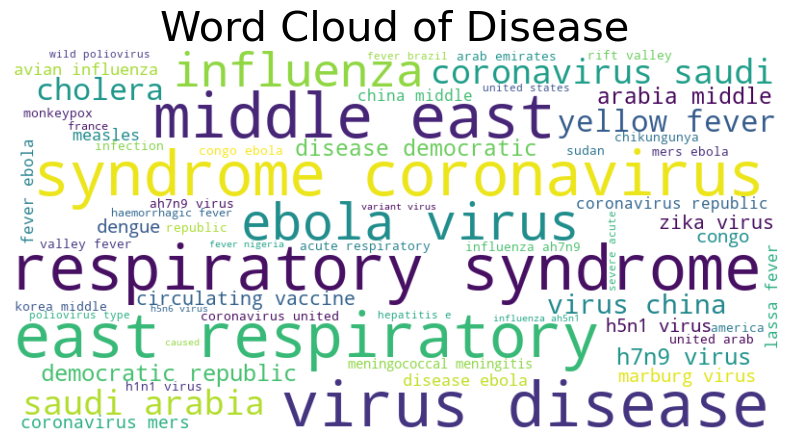

In [137]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# load the data
file_path = "who_webscraping.csv"
data = pd.read_csv(file_path)

# clean the data
# filter out rows where 'Disease' is "NA" or numeric
def is_valid_disease(disease):
    return isinstance(disease, str) and disease.strip().lower() != "na" and not disease.isdigit()

# apply the filter
valid_data = data[data['Disease'].apply(is_valid_disease)]

# normalize the disease names (convert to lowercase and remove punctuation)
def clean_text(text):
    # convert to lowercase
    text = text.lower()
    # remove punctuation and special characters using regex
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

valid_data['Disease'] = valid_data['Disease'].apply(clean_text)

# count disease frequencies
# concatenate all disease names into a single string
all_diseases = " ".join(valid_data['Disease'])

# generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis",
    min_font_size=10,
    max_words=100
).generate(all_diseases)

# visualize the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") 
plt.title("Word Cloud of Disease", fontsize=30)
plt.show()

We can also use a bar chart to show the frequency of disease outbreaks by country. By analyzing the tallest bars, we can see which countries have experienced the most outbreaks over time. It also allows us to compare the relative burden of outbreaks between countries.

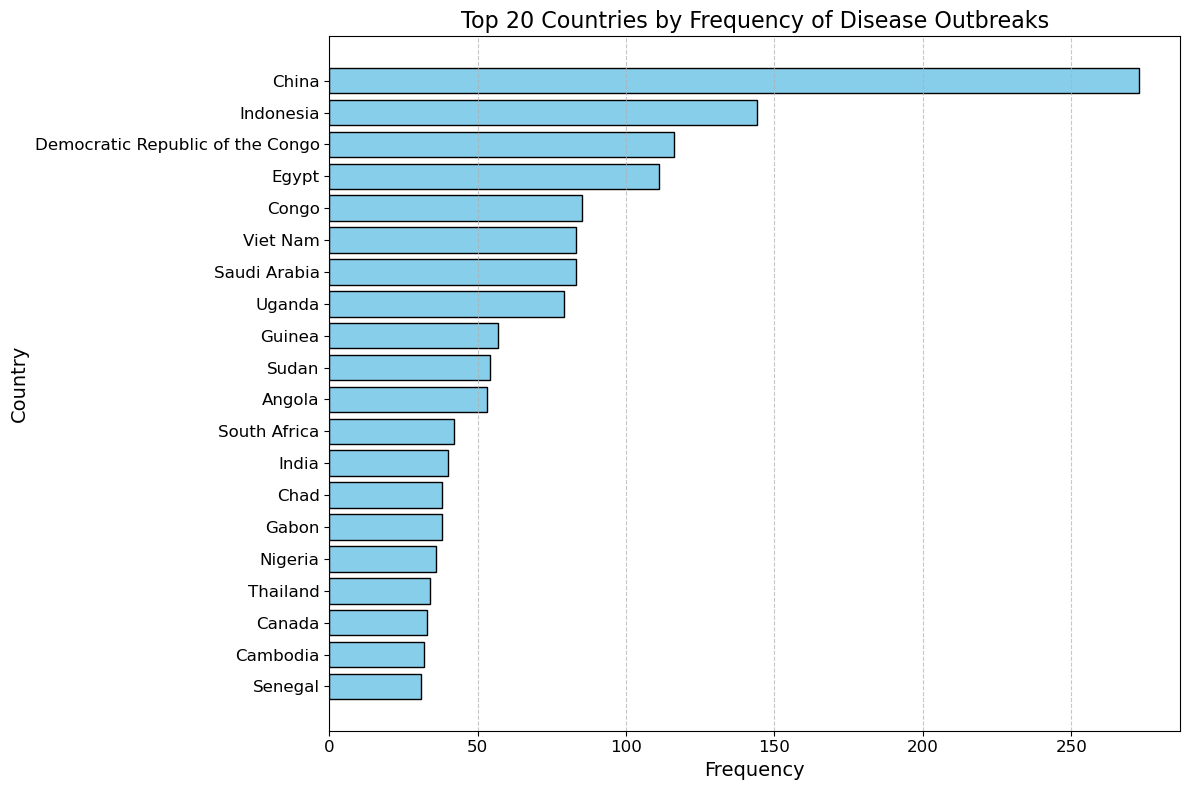

In [143]:
from collections import Counter

# extract the 'Country' column and clean the data
# remove rows where Country is "NA" or contains only numeric values
countries = data["Country"].dropna()  
cleaned_countries = [
    country.strip()
    for country in countries
    if isinstance(country, str) and country.strip() != "NA" and not country.strip().isdigit()
]

# count the frequency of each country
country_counts = Counter(cleaned_countries)

# sort the countries by frequency (descending order)
sorted_country_counts = dict(sorted(country_counts.items(), key=lambda item: item[1], reverse=True))

# create a bar chart to visualize the frequency of countries (here we can extract the top 20 countries for better visualization)
top_n = 20
top_countries = list(sorted_country_counts.keys())[:top_n]
top_frequencies = list(sorted_country_counts.values())[:top_n]

# plot the bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_countries, top_frequencies, color='skyblue', edgecolor='black')
plt.gca().invert_yaxis()  
plt.title("Top 20 Countries by Frequency of Disease Outbreaks", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Country", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# show the plot
plt.tight_layout()
plt.show()